## Richards Equation Toy model -- Trying the Julia Solvers

In [1]:
using DiffEqOperators,  DifferentialEquations,  Plots
using Parameters
using Revise
#from jupyterthemes import jtplot
#jtplot.style(theme=’monokai’, context=’notebook’, ticks=True, grid=False)

In [2]:
FT = Float64

include("Water/water_functions.jl")
include("Water/hydraulic_conductivity_composable.jl")
include("Water/matric_potential_composable.jl")

matric_potential

In [3]:
hydraulic_model = Havercamp{FT}();
matric_model    = vanGenuchten{FT}();

In [4]:
K_sat  = 0.0443 / (3600*100)
porosity = 0.495 # Read in from data base
S_s = 10e-4  # [ m-1] ## Check this value !!

#IC/BC values  - to be specified/calculated via a BC/IC struct, and treated as an attribute of the model.
ν_0 = 0.24
ν_surface = porosity-1e-3
S_l_0 = effective_saturation(porosity, ν_0)
ψ_0 = pressure_head(matric_model,S_l_0,porosity,S_s,ν_0)
println(ψ_0)
κ_0 = hydraulic_conductivity(hydraulic_model, K_sat, S_l_0, ψ_0)

-1.938733644779751


1.3548894996468134e-9

In [5]:
L  = 1.0 # depth in meters
nknots = 99 #99
dz = -L/(nknots+1)#1000.0/(nknots+1)
knots = range(dz, step=dz, length=nknots)

z = collect(knots)
ord_deriv = 2
ord_approx = 2

2

In [56]:
const Δ = CenteredDifference(ord_deriv, ord_approx, dz, nknots)
const ∇ = CenteredDifference(1, ord_approx, dz, nknots)
const bc = DirichletBC(ν_surface, ν_0)

RobinBC{Float64,Array{Float64,1}}([-0.0, 0.0], 0.494, [-0.0, 0.0], 0.24)

In [67]:
function soil_water(ν,p,t; porosity=porosity, S_s=S_s, HM=hydraulic_model, MM=matric_model, K_sat=K_sat, z=z )
    # Get effective saturation
    ν_ext = bc*ν
    S_l = map(x -> effective_saturation(porosity,x),ν_ext)
    #@show size(S_l)
    # This function calculates pressure head ψ of a soil
    ψ = similar(S_l)
    for i in eachindex(ψ)
        ψ[i] = pressure_head(MM, S_l[i],porosity,S_s,ν_ext[i])
    end
    
    # Get hydraulic head
    #h = hydraulic_head(z,ψ)
    
    # Conductivity
    K = map(x -> hydraulic_conductivity(HM,K_sat,x,0.0),S_l)
    dKdz = ∇*K
    #@show size(K)
    #@show size(∇*ψ)
    #@show size(K[2:end-1]*Δ*ψ)
    #@show size(∇*ψ)
    #@show size(dKdz)
    # somehow, I don't get the sizes right...
    K[2:end-1]*Δ*ψ + (∇*ψ) .* dKdz + dKdz

end

soil_water (generic function with 1 method)

In [68]:
ν = ν_0*ones(99);
soil_water(ν,1,0);

In [69]:
tmax = 86400.0
prob = ODEProblem(soil_water, ν, (0.0, tmax))
alg = KenCarp4(autodiff=false)
sol = solve(prob, alg)
#sol_times = [sol(t) for t in 0.0:dt:tmax]

retcode: Success
Interpolation: 3rd order Hermite
t: 36-element Array{Float64,1}:
     0.0
     0.31710943877988146
     3.488203826578696
    14.633941521295885
    31.043591179525396
    58.282621289356456
    99.5064212789953
   161.5624084895531
   250.72941096652096
   374.54965684425906
   540.3323941619859
   757.7698936024334
  1037.7671735485217
     ⋮
 16671.980739815754
 19923.734692175916
 23672.040741964585
 27969.967046793077
 32868.097013265164
 38421.820950212925
 44697.70908142087
 51770.60819529647
 59716.34546422361
 68604.1671009562
 78495.70810212013
 86400.0
u: 36-element Array{Array{Float64,1},1}:
 [0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24  …  0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24]
 [0.24074598381248816, 0.2400029867665909, 0.24000000801626786, 0.24000000001616392, 0.24000000000002353, 0.24000000000000002, 0.24, 0.24, 0.24, 0.24  …  0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24]
 [0.24761159236384486, 0.24031582

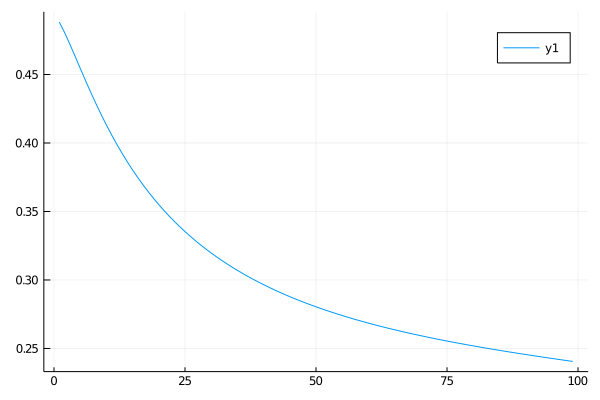

In [76]:
plot(sol[end])

In [33]:
matrix(∇*bc)

UndefVarError: UndefVarError: matrix not defined